In [1]:
#import packages
#importing packages
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sweetviz
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, recall_score, precision_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,PowerTransformer
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,RepeatedKFold,GridSearchCV

import time
from imblearn.over_sampling import SMOTE 
from collections import Counter

import lime
from lime import lime_tabular
import shap


In [2]:
# this will evaluate models, calculate ROC and generate confusion matrix
def evaluate_model(model,df_model,model_type,plt_color, X_train, y_train, X_test, y_test):
    y_train_pred= model.predict(X_train)
    y_test_pred= model.predict(X_test)
    train_roc=roc_auc_score(y_train,y_train_pred)
    test_roc=roc_auc_score(y_test,y_test_pred)
    print("Train Evaluation Score:- ")
    print("ROC AUC Score:-", "{:.2f}".format(train_roc))
    print("Confusion Matrix:- ")
    df_eval = pd.DataFrame(confusion_matrix(y_train, y_train_pred),
                          columns=['Predicted Negative','Predicted Positive'],
                          index = ['Actual Negative','Actual Positive'])
    print(df_eval)
    print("Test Evaluation Score:- ")
    print("ROC AUC Score:-", "{:.2f}".format(test_roc))
    print("Confusion Matrix:- ")
    df_eval = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                          columns=['Predicted Negative','Predicted Positive'],
                          index = ['Actual Negative','Actual Positive'])
    print(df_eval)

    y_pred_train_proba = model.predict_proba(X_train)[:,1] 
    y_test_proba = model.predict_proba(X_test)
    #Accuracy = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)
    precision = precision_score(y_train, y_train_pred, average='binary')
    recall = recall_score(y_train, y_train_pred, average='binary')
    #test_roc = roc_auc_score(y_test, y_test_proba)
    df_model = df_model.append(pd.DataFrame({'Model': [model_type],'Accuracy':  [metrics.accuracy_score(y_pred=y_train_pred, y_true=y_train)],'Precision':[precision],'Recall':[recall],'F1':[metrics.f1_score(y_pred=y_train_pred, y_true=y_train)],'ROC':[train_roc], 'Test_ROC':[test_roc] }))
    # Plotting ROC AUC Score
    #y_test_proba = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    
    fpr1, tpr1, thresh1 = roc_curve(y_test,y_test_proba[:,1], pos_label=1)
    random_probs=[0 for i in range(len(y_test))]
    p_fpr, p_tpr , _ = roc_curve(y_test, random_probs, pos_label=1)
    plt.style.use('seaborn')
    plt.plot(fpr1, tpr1, linestyle='--', color=plt_color, label=model_type)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    #plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
    plt.show
    
    return df_model

In [3]:
df_loan = pd.read_csv("Model_data.csv")
df_loan.drop('Unnamed: 0',axis=1, inplace=True)


In [4]:
df_loan.shape

(207589, 22)

In [5]:
#Create a dataframe to store results
df_model = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall','F1','ROC','Test_ROC'])

In [6]:
y= df_loan.pop('TARGET') #class variable-- target variable
X = df_loan#features
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 191193, 0: 191193})


In [7]:
from sklearn import model_selection
X_train, X_test, y_train, y_test =  model_selection.train_test_split(X_res, y_res, test_size=0.2, random_state = 42)

Train Evaluation Score:- 
ROC AUC Score:- 0.94
Confusion Matrix:- 
                 Predicted Negative  Predicted Positive
Actual Negative              150186                2731
Actual Positive               16658              136333
Test Evaluation Score:- 
ROC AUC Score:- 0.94
Confusion Matrix:- 
                 Predicted Negative  Predicted Positive
Actual Negative               37619                 657
Actual Positive                4247               33955


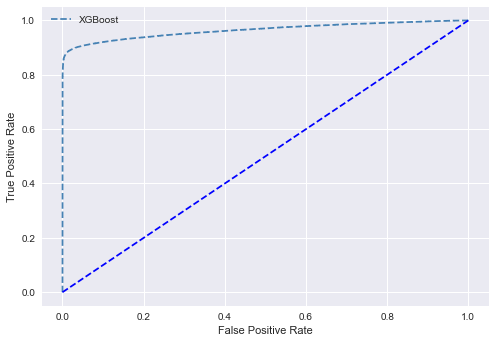

In [8]:
XGBmodel = XGBClassifier(max_depth=2, n_estimators=200, eval_metric='logloss',learning_rate=0.6,subsample=0.9,random_state=42)
XGBmodel.fit(X_train, y_train)
df_model=evaluate_model(XGBmodel,df_model,'XGBoost','steelblue', X_train, y_train, X_test, y_test)

Train Evaluation Score:- 
ROC AUC Score:- 0.90
Confusion Matrix:- 
                 Predicted Negative  Predicted Positive
Actual Negative              138427               14490
Actual Positive               16408              136583
Test Evaluation Score:- 
ROC AUC Score:- 0.83
Confusion Matrix:- 
                 Predicted Negative  Predicted Positive
Actual Negative               31683                6593
Actual Positive                6778               31424


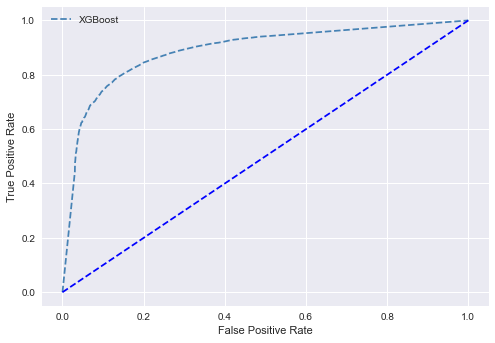

In [9]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(min_samples_leaf=5,max_depth=20,criterion='gini',  random_state=42)
dt.fit(X_train, y_train)
df_model=evaluate_model(dt,df_model,'XGBoost','steelblue', X_train, y_train, X_test, y_test)

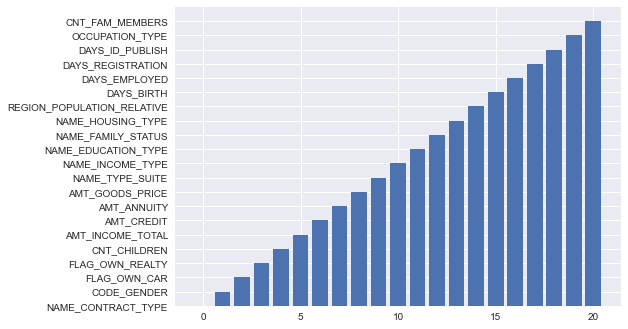

In [10]:
plt.bar(range(len(XGBmodel.feature_importances_)), df_loan.columns)
plt.show()

<BarContainer object of 21 artists>

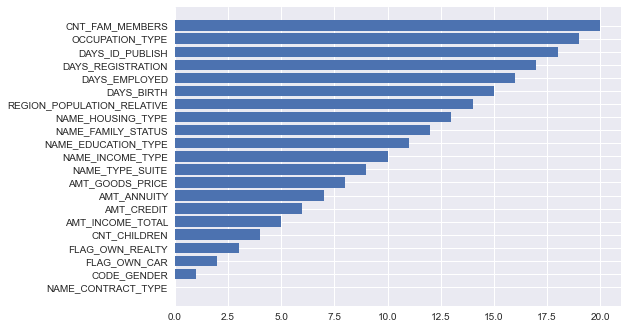

In [13]:
plt.barh(df_loan.columns, range(len(XGBmodel.feature_importances_)))


<BarContainer object of 21 artists>

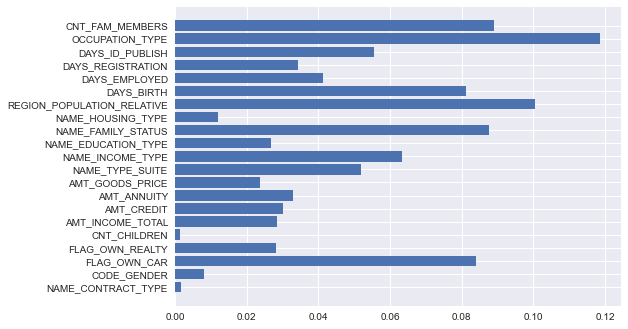

In [12]:
plt.barh(df_loan.columns, dt.feature_importances_)

In [14]:
explainer = shap.TreeExplainer(XGBmodel)
shap_values = explainer.shap_values(X_train)

In [15]:
shap.initjs()

In [16]:
i = 4
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns)

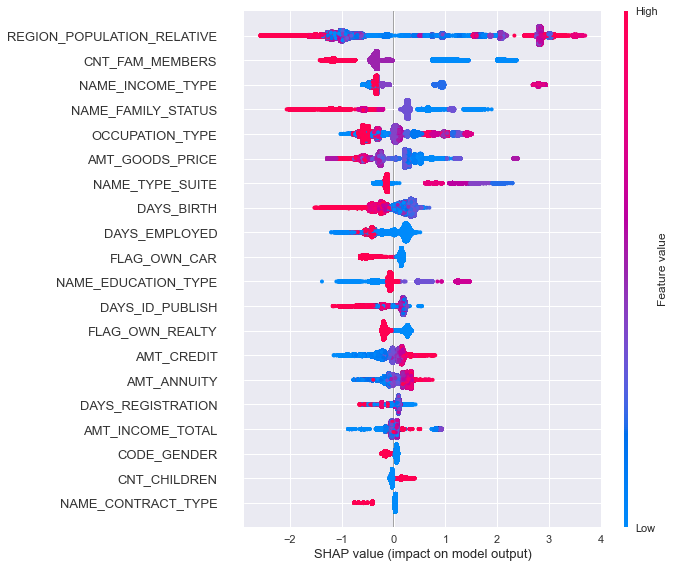

In [16]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

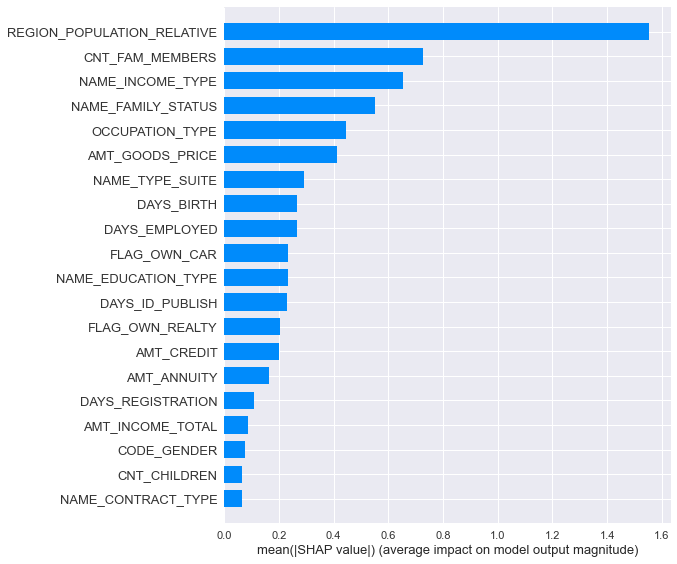

In [17]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')


### LIME


### With Decision Tree

In [64]:
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_train)

In [65]:
shap.initjs()

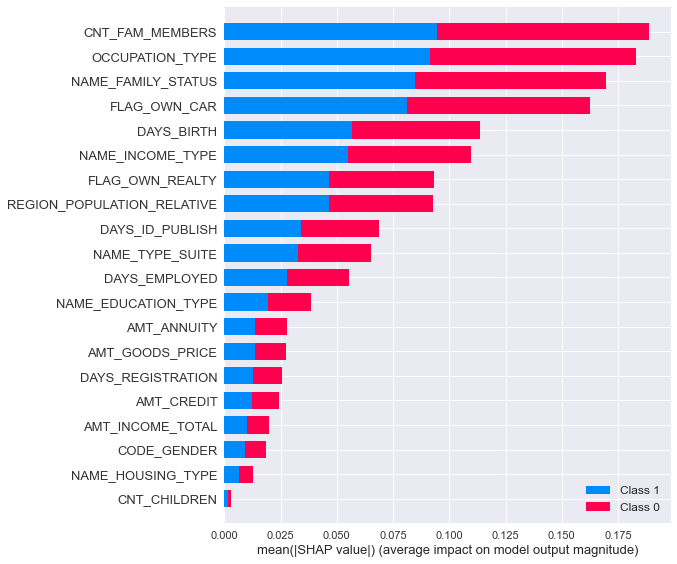

In [69]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

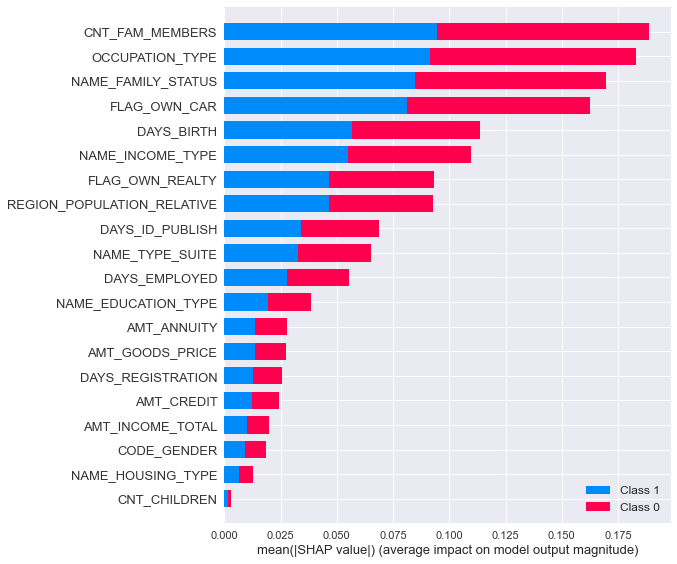

In [70]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')


In [19]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Legitimate', 'Default'],
    mode='classification'
)

In [20]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[4], 
    predict_fn=XGBmodel.predict_proba, num_features=5
)

exp.show_in_notebook(show_all=False)

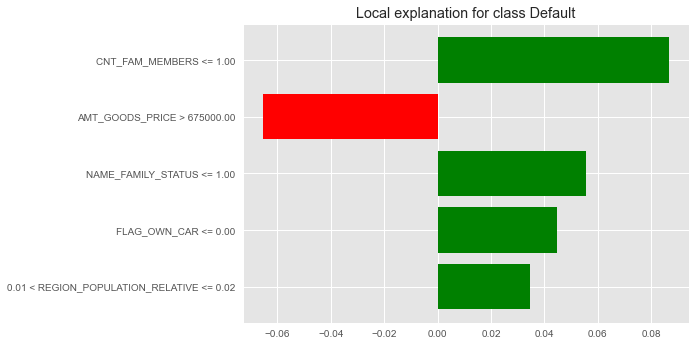

In [73]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()

In [21]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[4], 
    predict_fn=dt.predict_proba, num_features=5
)

exp.show_in_notebook(show_all=False)

In [22]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[4], 
    predict_fn=dt.predict_proba, num_features=5
)

exp.show_in_notebook(show_all=False)

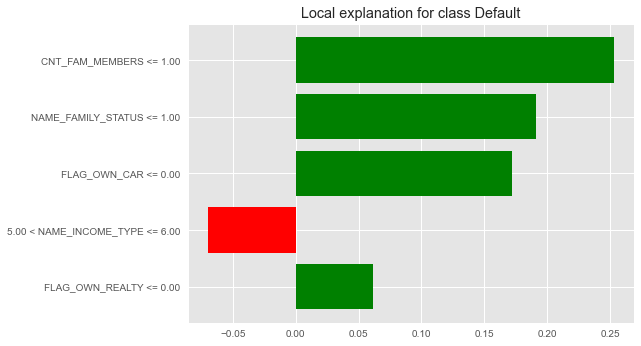

In [75]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()